In [165]:
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np

import os, sys

import utils

from best_utils import *
from cross_validation import cross_validation
import image_preprocessing

from skimage import color

import keras

from skimage.color import rgb2hsv

from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, LeakyReLU, Dropout

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
ROOT_DIR = 'training/'
IMAGE_DIR = ROOT_DIR + 'images/'
GT_DIR = ROOT_DIR + 'groundtruth/'

PATCH_SIZE = 10

In [188]:
# Read images, change to hsv, saturate and stack into a tensor
files = os.listdir(IMAGE_DIR)

imgs = np.stack([load_image(IMAGE_DIR + file) for file in files]) # images (400, 400, 3)
gt_imgs = np.stack([load_image(GT_DIR + file) for file in files]) # images (400, 400)

patched_imgs = np.stack([patch_image(img, PATCH_SIZE) for img in imgs]) # images (400, 400)
patched_gts = np.stack([patch_groundtruth(gt, PATCH_SIZE) for gt in gt_imgs])

In [206]:
PATCHED_SIZE = imgs.shape[1] // PATCH_SIZE
WINDOW_SIZE = 65
WINDOWS_PER_IMAGE = PATCHED_SIZE ** 2

In [187]:
N = 1 # Number of image to be used in training

leakyness = 0.1

In [207]:
windows_per_image = [image_to_features(im, WINDOW_SIZE, True) for im in patched_imgs[:N]]
windows = np.vstack(windows_per_image)

window_labels = np.ravel(patched_gts[:N])
assert window_labels.shape[0] == windows.shape[0]

In [208]:
window_cnn = keras.models.Sequential([
    
    Conv2D(32, (5, 5), strides=(1, 1), input_shape=windows.shape[1:]),
    LeakyReLU(leakyness),
    
    MaxPooling2D(2),

    Conv2D(64, (3, 3), strides=(1, 1)),
    LeakyReLU(leakyness),
    
    MaxPooling2D(2),
    
    Conv2D(128, (3, 3), strides=(1, 1)),
    LeakyReLU(leakyness),
    
    MaxPooling2D(2),
    
    Conv2D(256, (3, 3), strides=(1, 1)),
    LeakyReLU(leakyness),

    MaxPooling2D(2),
    
    Dense(128),
    LeakyReLU(leakyness),
    
    Flatten(),
    Dense(1),#, activation='softmax'),
    LeakyReLU(leakyness),
])

In [209]:
window_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 61, 61, 32)        2432      
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 61, 61, 32)        0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 12, 12, 128)       73856     
__________

In [210]:
window_cnn.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])

In [211]:
nw = windows.shape[0]
def batch_generator():
    while True:
        indices = np.random.choice(range(nw), 200, replace=False)
        yield (windows[indices], window_labels[indices])

In [212]:
def smart_generator(n_windows, n_epochs):
    ws_per_epoch = n_windows // n_epochs
    indices = np.random.choice(range(n_windows), n_epochs*ws_per_epoch, replace=False)
    indices_per_epoch = [indices[i:i+ws_per_epoch] for i in range(0, n_windows, ws_per_epoch)]
    for batch_idx in indices_per_epoch:
        ws = windows[batch_idx]
        labs = window_labels[batch_idx]
        yield (ws, labs)

In [213]:
epochs = 10

In [214]:
window_cnn.fit(windows, window_labels, epochs=epochs)
#window_cnn.fit_generator(smart_generator(windows.shape[0], epochs), steps_per_epoch=windows.shape[0] // epochs, epochs=10)

Epoch 1/10
1600/1600 [==============================] - 16s - loss: 0.5480 - acc: 0.7881    
Epoch 2/10
1600/1600 [==============================] - 22s - loss: 0.5024 - acc: 0.7881    
Epoch 3/10
1600/1600 [==============================] - 19s - loss: 0.4908 - acc: 0.7881    
Epoch 4/10
1600/1600 [==============================] - 19s - loss: 0.4616 - acc: 0.7881    
Epoch 5/10
1600/1600 [==============================] - 18s - loss: 0.4115 - acc: 0.8094    
Epoch 6/10
1600/1600 [==============================] - 18s - loss: 0.3568 - acc: 0.8631    
Epoch 7/10
1600/1600 [==============================] - 18s - loss: 0.3766 - acc: 0.8425    
Epoch 8/10
1600/1600 [==============================] - 18s - loss: 0.3257 - acc: 0.8681    
Epoch 9/10
1600/1600 [==============================] - 19s - loss: 0.2850 - acc: 0.8762    
Epoch 10/10
1600/1600 [==============================] - 18s - loss: 0.2455 - acc: 0.8875    


# Test on a never seen image

In [221]:
i = 0

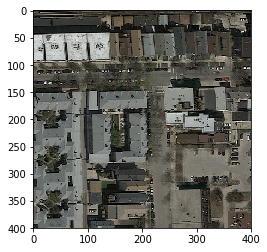

In [222]:
plt.imshow(imgs[i])

In [223]:
window_t = image_to_features(patched_imgs[i], WINDOW_SIZE, True)

In [224]:
preds = window_cnn.predict(window_t)

In [225]:
f = np.ravel(preds)
f = np.reshape(f, (40, 40))

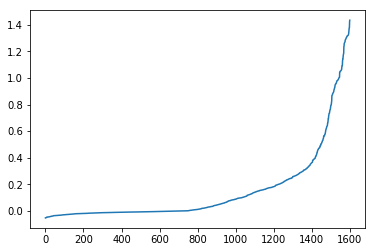

In [226]:
plt.plot(np.sort(np.ravel(f)))

In [227]:
f[f < 0.5] = 0
f[f >= 0.5] = 1

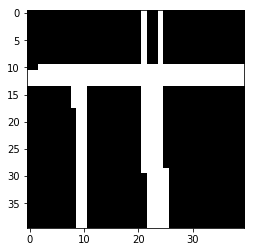

In [228]:
plt.imshow(patched_gts[i], cmap='Greys_r')

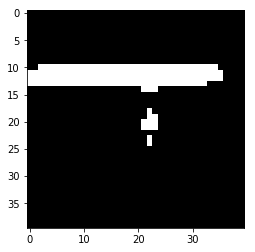

In [229]:
plt.imshow(f, cmap='Greys_r')

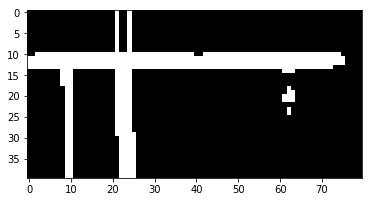

In [230]:
plt.imshow(np.hstack([patched_gts[i], f]), cmap='Greys_r')